Notebook purpose

- Sense-check and explore calculated account balances

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))

Rows: 673,277
Users: 220


## By account type

### Balances over time

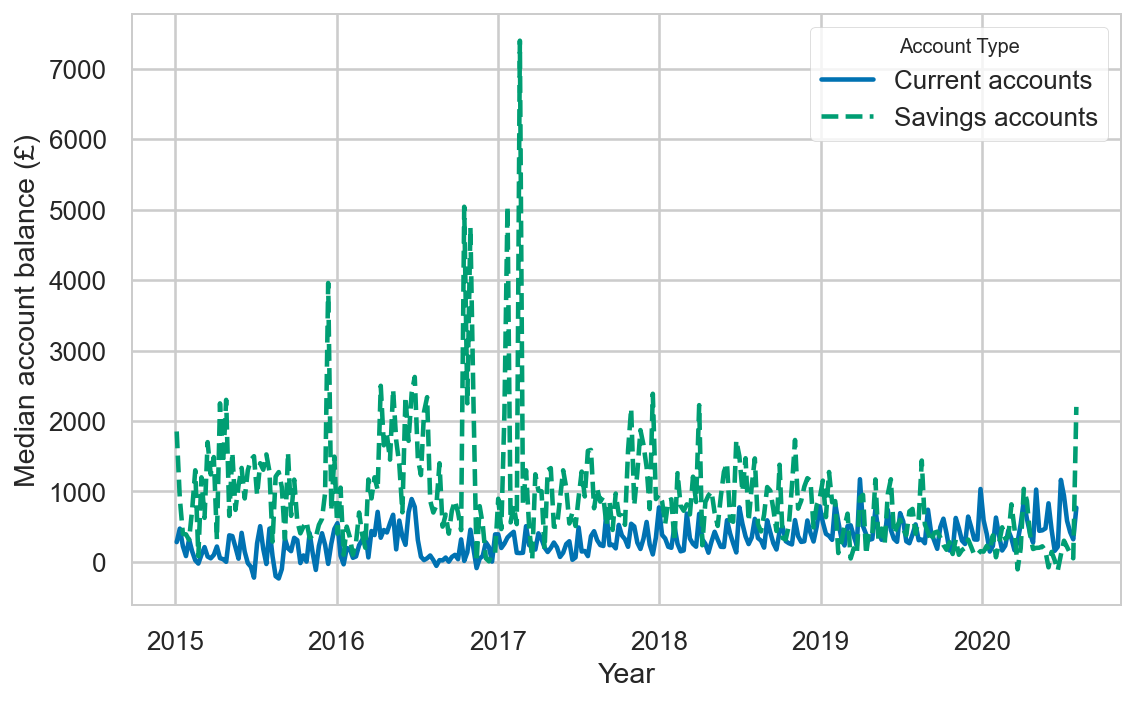

In [137]:
figs.balances_by_account_type(df, write=False)

In [9]:
def median_balance(df, account_type='current', freq='w'):
    """Calculate median balance account type."""
    return (df.loc[df.account_type == account_type]
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1)
            .groupby('date').median()
            .resample(freq).median())

In [4]:
current_account_balances = median_balance(df, account_type='current', freq='w')
savings_account_balances = median_balance(df, account_type='savings', freq='w')
credit_card_balances = median_balance(df, account_type='credit card', freq='w')
users = df.resample('w', on='date').user_id.nunique()

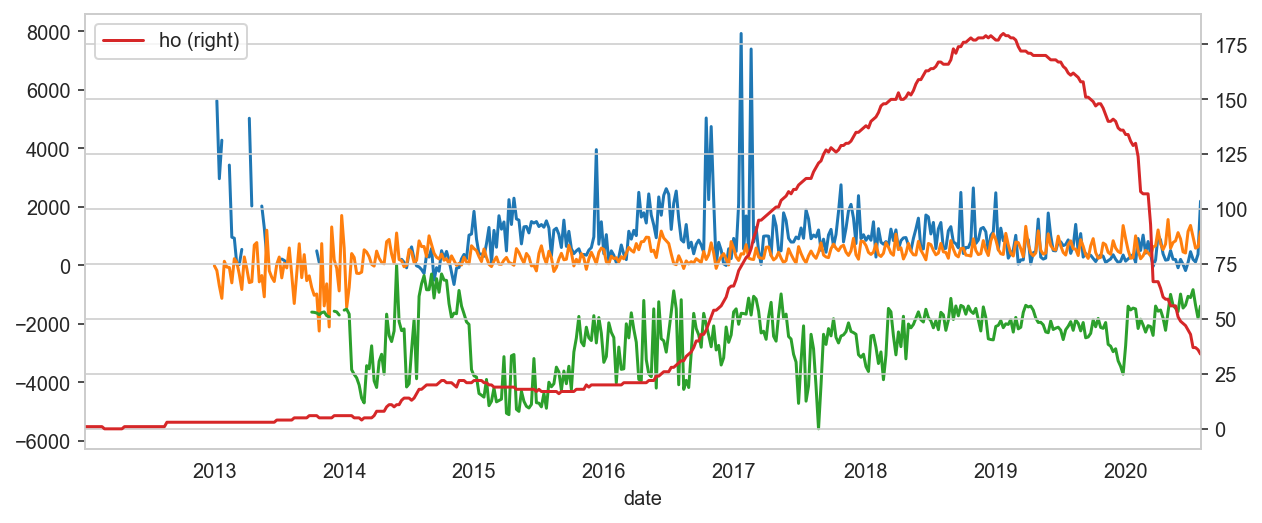

In [5]:
plotargs = dict(figsize = (10, 4))
savings_account_balances.plot(**plotargs, label='savings')
current_account_balances.plot(**plotargs, label='current')
credit_card_balances.plot(**plotargs, label='credit')
users.plot(**plotargs, secondary_y=True, label='ho')
plt.legend();

### Within-year pattern

## By user

Total balance of user across all observed accounts as measure of savings (check for missing balance accounts)

## Balances over time

Below shows median of median weekly balances.

## Monthly current-account balance pattern

2018 data for monthly pattern

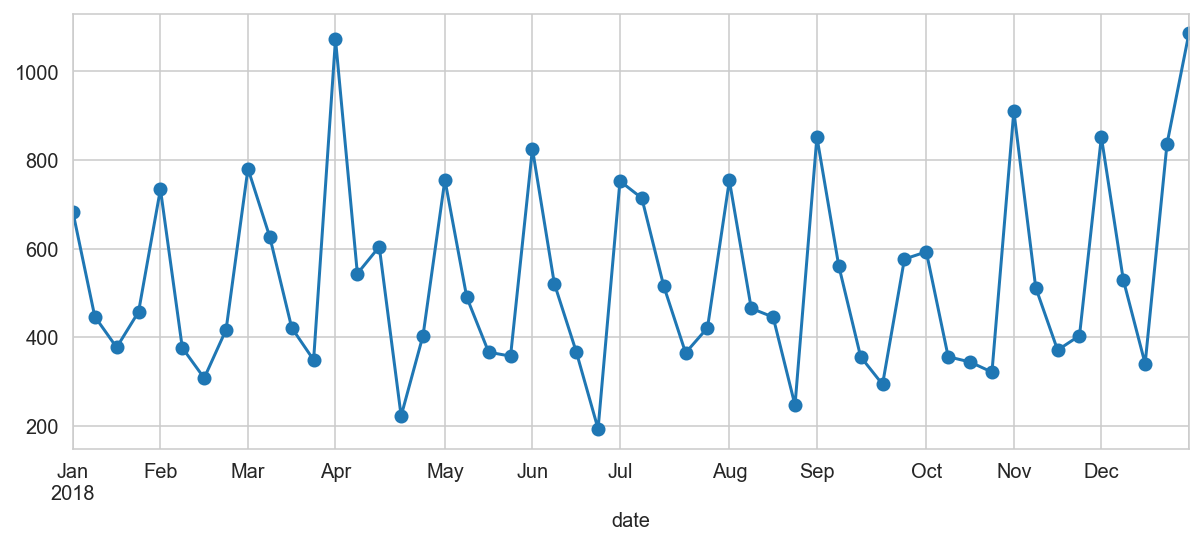

In [13]:
current_account_balances.loc['2018'].plot(**plotargs, marker='o');

In [143]:
current_account_balances.loc['Jul 2018']

date
2018-07-01    752.432495
2018-07-08    713.799438
2018-07-15    515.629639
2018-07-22    364.769623
2018-07-29    421.310669
Freq: W-SUN, Name: balance, dtype: float32

As expected, balances are high around salary payment dates and then decline throughout the month

## Income-scaled balances

Plot weekly median (across weekdays) of daily median current account balance divided by monthly income (across users).

In [9]:
daily_balance = (df.loc[df.account_type == 'current']
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1))

monthly_income = (df.set_index('date')
                  .groupby('user_id')
                  .resample('d').income.first()
                  .div(12))

scaled_balance = (daily_balance
                  .div(monthly_income)
                  .rename('scaled_balance'))

weekly_agg_scaled_balance = (scaled_balance
                             .resample('d', level='date').median()
                             .resample('w').median())

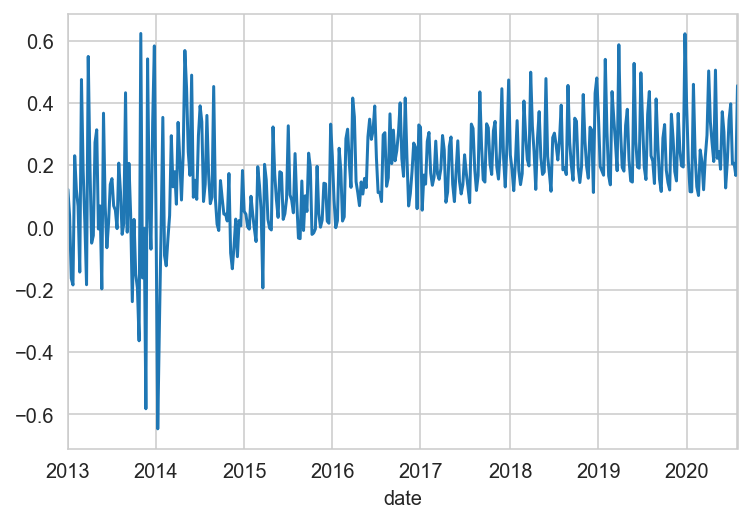

In [10]:
weekly_agg_scaled_balance.loc['2013':].plot();

Monthly pattern in 2018

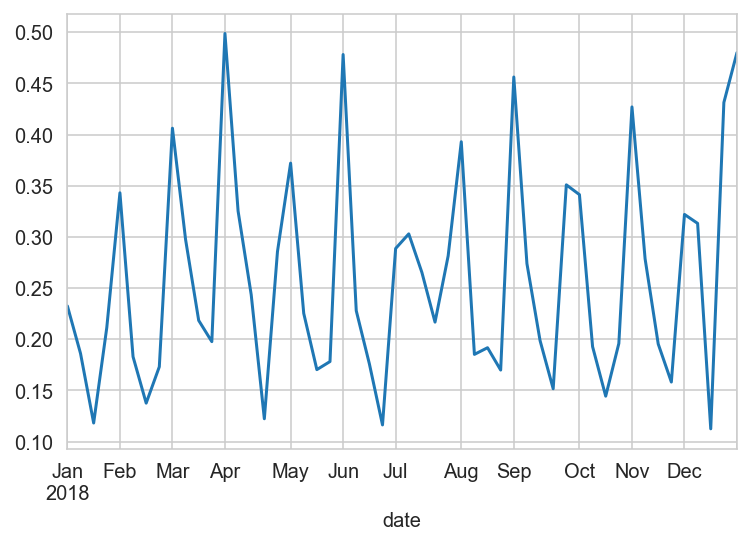

In [11]:
weekly_agg_scaled_balance.loc['2018'].plot();

## Case studies

### Users

In [3]:
SAMPLE_SIZE = df.user_id.nunique()
SAMPLE_SIZE = 2

rng = np.random.default_rng(seed=2312)
user_sample = rng.choice(df.user_id.unique(), size=SAMPLE_SIZE)
mask = df.user_id.isin(user_sample)

daily_balances = (df[mask]
                  .set_index('date')
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str'))
                  .groupby(['account_label', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id'))

daily_balances.head(2)

,account_label,user_id,date,balance
0,current-278242,84777,2014-04-04,839.7099
305,current-278244,84777,2014-08-23,430.0000


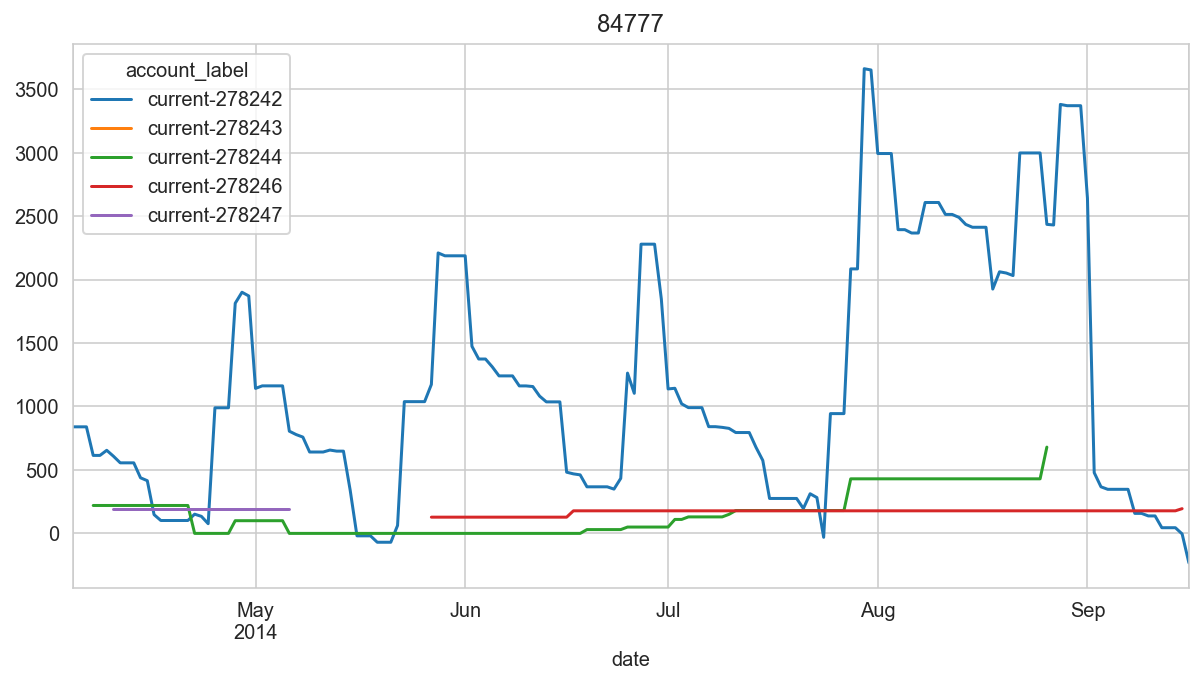

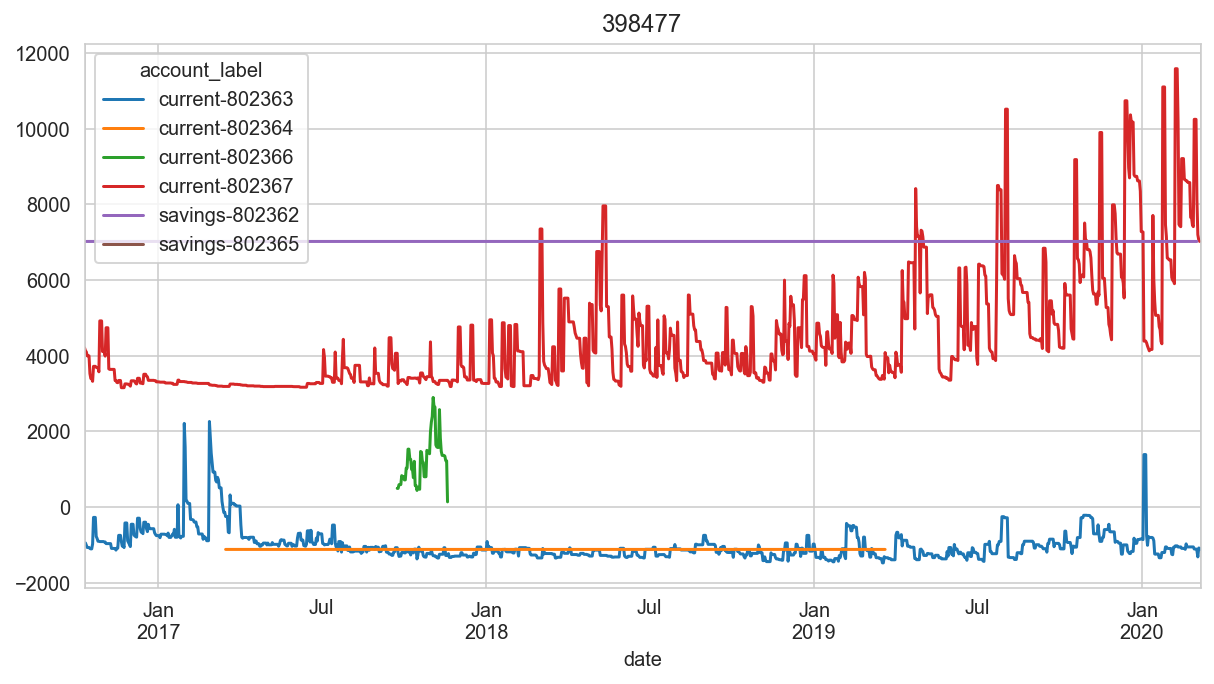

In [4]:
for id, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5), title=id);

### Savings accouns

In [7]:
savings_balances = (df[df.account_type == 'savings']
                    .assign(account_label=lambda x: 
                            x.account_id.astype('str') + '-' 
                            + x.user_id.astype('str'))
                    .set_index('date')
                    .groupby(['account_label'])
                    .resample('D').balance.first()
                    .fillna(method='ffill')
                    .dropna()
                    .reset_index())

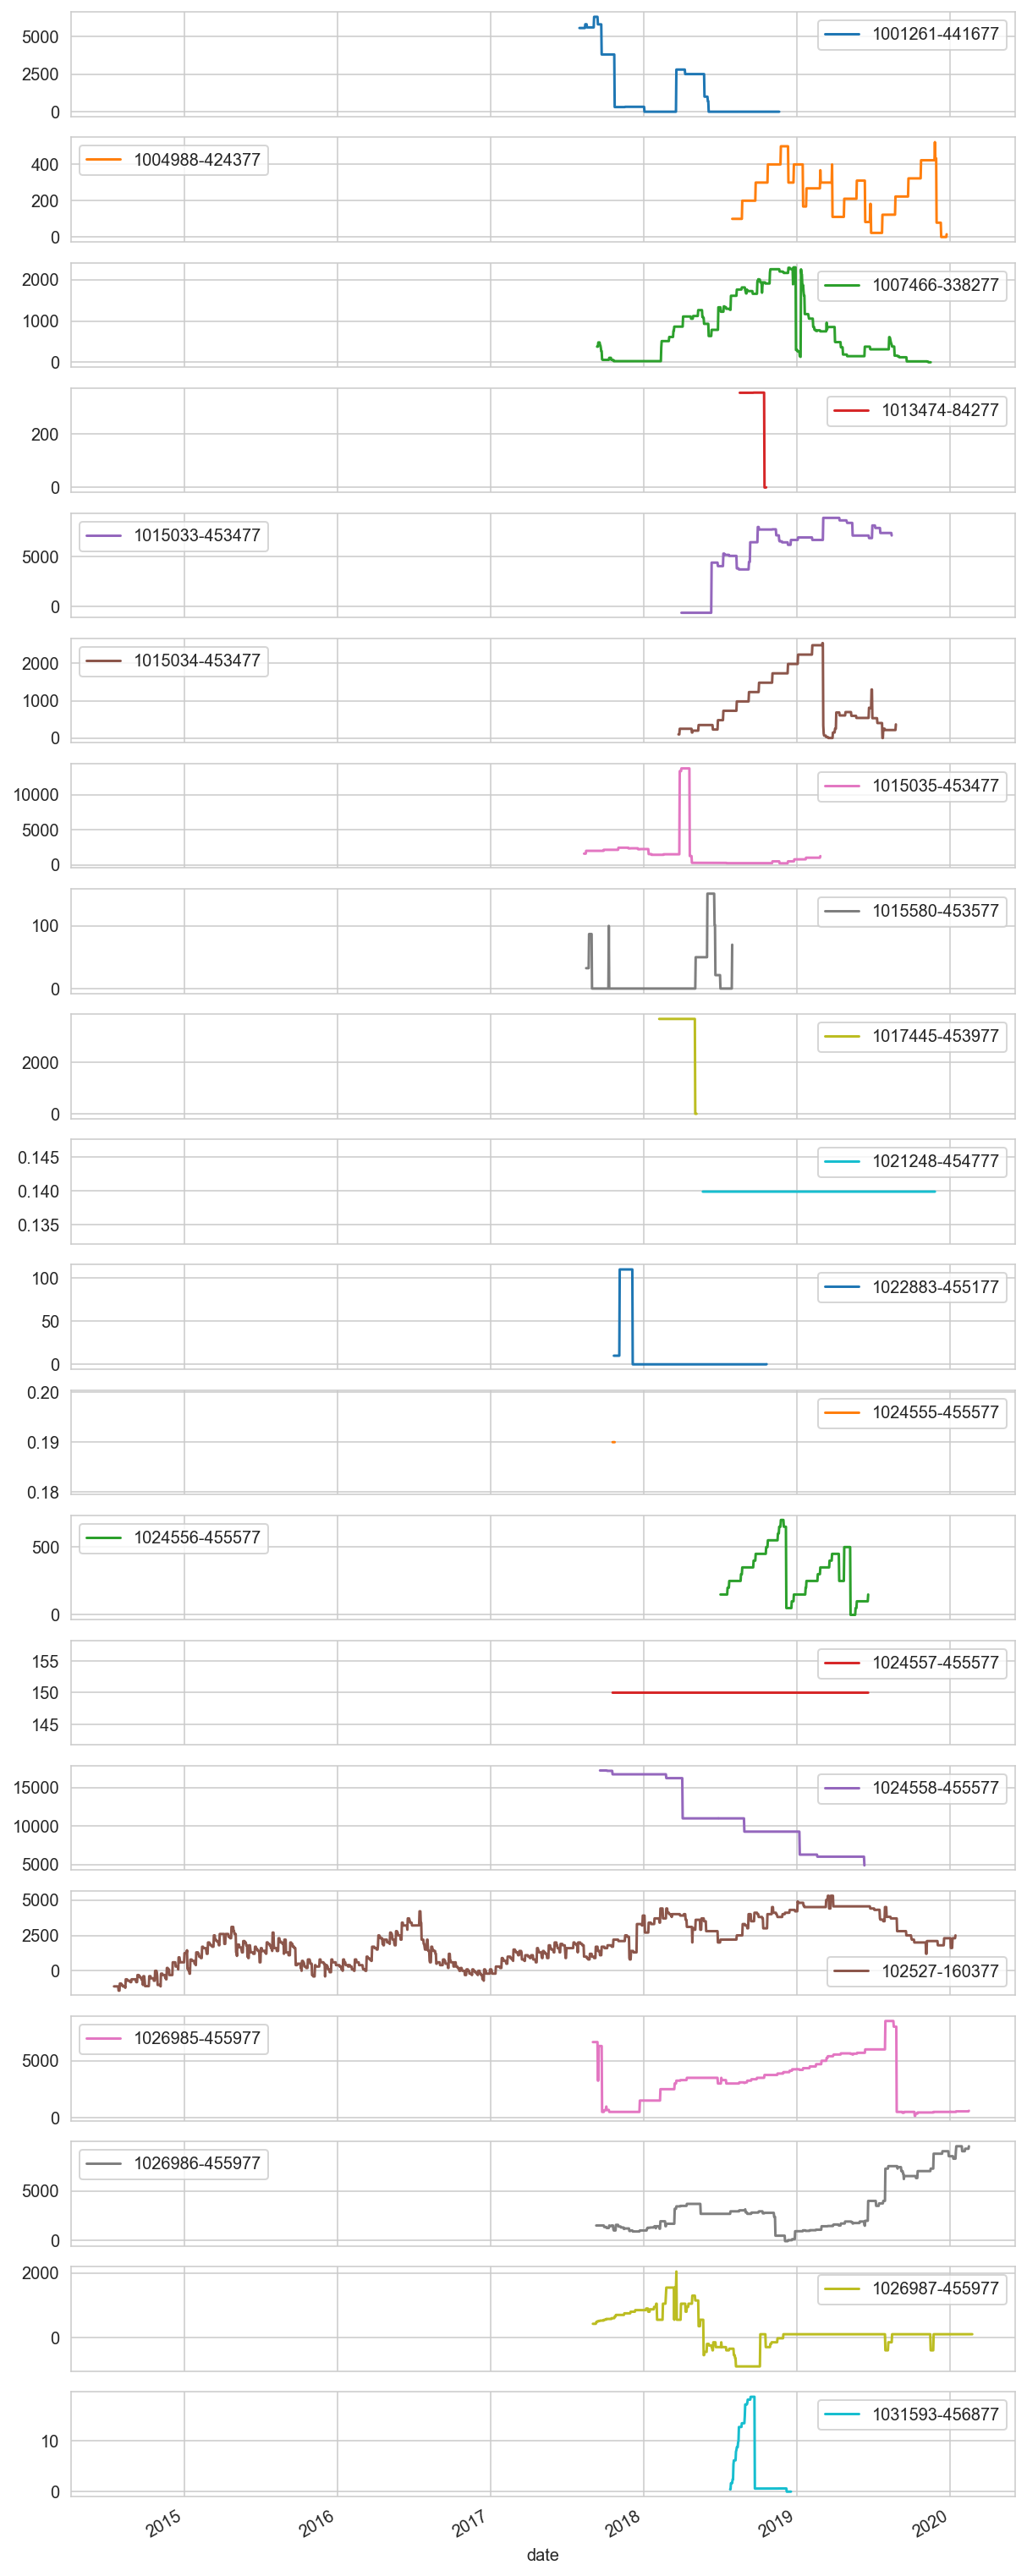

In [8]:
SAMPLE_SIZE = 20
savings_balances.pivot('date', 'account_label', 'balance').iloc[:, :SAMPLE_SIZE].plot(subplots=True, figsize=(10, 30));